# Lesson 5.08 Word Vectors

## word2vec (Word to Vector)
- Word2vec is a function that accepts a text corpus as an input and returns a set of vectors (also known as embeddings)
- Each vector is a numeric representation of a given word. 
- Each value in the vector represents a context (surrounding) word of the given word.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import gensim.utils
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

# Install gensim
# !pip install --upgrade gensim

## Load Data
- Data Source: https://www.kaggle.com/datasets/omkarsabnis/yelp-reviews-dataset

In [2]:
df_reviews = pd.read_csv('reviews.csv')
pd.set_option('display.max_colwidth', 100)

In [3]:
df_reviews.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,"I have no idea why some people give bad reviews about this place. It goes to show you, you can p...",review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I also dig their candy selection :),review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!! It's very convenient and surrounded by a lot of ...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,"General Manager Scott Petello is a good egg!!! Not to go into detail, but let me assure you if y...",review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## Explore Data

In [4]:
# Display number of reviews for each star rating
print("Number of rows per star rating:")
print(df_reviews['stars'].value_counts())

Number of rows per star rating:
4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64


In [5]:
# Create a function to map each star rating to a specific sentiment
## -1 refer to negative sentiment 
## 0 refers to neutral sentiment
## 1 refers to positive sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
    
# Mapping stars to sentiment category for each review
df_reviews['sentiment'] = [map_sentiment(x) for x in df_reviews['stars']]

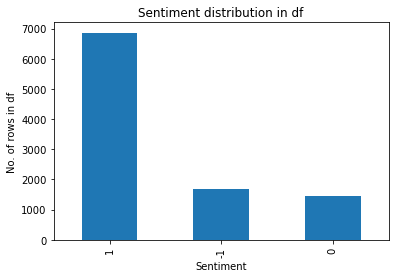

In [6]:
# Plot sentiment distribution
plt.figure()
pd.value_counts(df_reviews['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

## Prepare Data (for modelling)
- As seen above, the number of rows are not equally distributed across the 3 sentiment categories resulting in class imbalance
- Class imbalance affects model performance and needs to be dealt with prior to modelling

In [7]:
# Create a function to retrieve first n rows per sentiment category
# top_n refers to the first (top) n rows per sentiment category
def get_top_data(top_n):
    top_data_df_positive = df_reviews[df_reviews['sentiment'] == 1].head(top_n)
    top_data_df_negative = df_reviews[df_reviews['sentiment'] == -1].head(top_n)
    top_data_df_neutral = df_reviews[df_reviews['sentiment'] == 0].head(top_n)
    top_data_df_reviews = pd.concat([top_data_df_positive, top_data_df_negative, top_data_df_neutral])
    return top_data_df_reviews

# Invoke to get the first 1000 from each sentiment category
top_data_df_reviews = get_top_data(top_n=1000)

# Preview class distribution after selecting equal number of samples of each sentiment category
print("Number of rows for each sentiment category:")
print(top_data_df_reviews['sentiment'].value_counts())

Number of rows for each sentiment category:
 1    1000
-1    1000
 0    1000
Name: sentiment, dtype: int64


In [8]:
# Clean data (remove punctuations and tokenize) using the built in cleaner in gensim
# Removal of stop words is not done since it can alter the sentiment category e.g. "Food is not good" becomes "Food is good"
top_data_df_reviews['text_clean'] = top_data_df_reviews['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
top_data_df_reviews[['text', 'text_clean']].head()

,text,text_clean
0,My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect...,"[my, wife, took, me, here, on, my, birthday, for, breakfast, and, it, was, excellent, the, weath..."
1,"I have no idea why some people give bad reviews about this place. It goes to show you, you can p...","[have, no, idea, why, some, people, give, bad, reviews, about, this, place, it, goes, to, show, ..."
2,love the gyro plate. Rice is so good and I also dig their candy selection :),"[love, the, gyro, plate, rice, is, so, good, and, also, dig, their, candy, selection]"
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!! It's very convenient and surrounded by a lot of ...","[rosie, dakota, and, love, chaparral, dog, park, it, very, convenient, and, surrounded, by, lot,..."
4,"General Manager Scott Petello is a good egg!!! Not to go into detail, but let me assure you if y...","[general, manager, scott, petello, is, good, egg, not, to, go, into, detail, but, let, me, assur..."


## Build Word2Vec Model
- Ensure that all the sentiment categories have close to the same number of rows in both Train and Test data sets
- Train Word2Vec model using GenSim. More info at https://radimrehurek.com/gensim/models/word2vec.html 

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_reviews[['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id', 'text_clean']], 
                                                    top_data_df_reviews['sentiment'],
                                                    test_size=0.3, 
                                                    random_state=15)
print("Train Data - Class Distribution")
print(Y_train.value_counts())
print()
print("2. Test Data - Class Distribution")
print(Y_test.value_counts())

# All sentiment categories have close to the same number of rows in both Train and Test data sets

Train Data - Class Distribution
 0    707
-1    700
 1    693
Name: sentiment, dtype: int64

2. Test Data - Class Distribution
 1    307
-1    300
 0    293
Name: sentiment, dtype: int64


In [10]:
# Train the word2vec model
# vector_size = size of word vector. size input all dimensions that meet window param value
# window = number of words before and after the focus word that will be considered as context
# min_count = number of times word must appear in corpus in order to create a word vector
### Important - Model will only be trained on words that meet min_count so it may not learn all words as a result
w2v_model = Word2Vec(X_train["text_clean"], vector_size=100, window=5, min_count=2)

In [11]:
# create a list to store the average of all word vectors for each row of data
review_vect_list = []

# Iterate through each row in X train data
for index, row in X_train.iterrows():

    # Create a Word2Vec vector for each row (review) in train data 
    # By applying the W2V model on each word of each review, we get the word vector (embedding) for each word
    # Each row (review) will be represented by average of all vectors of all words in each row that model has trained on
    model_vector = (np.mean([w2v_model.wv.get_vector(token) for token in row['text_clean'] if token in w2v_model.wv], axis=0)).tolist()

    # Check if the line exists else it is vector of zeros
    if type(model_vector) is list:  
        review_vect_list.append(model_vector)
    else:
        review_vect_list.append([str(0) for i in range(100)])
        
word2vec_df = pd.DataFrame(review_vect_list)
word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.059742,0.425268,0.08742,0.035575,0.024538,-0.685716,0.250927,1.036605,-0.395876,-0.409718,...,0.35428,0.071245,0.023409,-0.00593,0.565007,0.322709,0.032677,-0.435146,0.150439,-0.099457
1,0.046372,0.420226,0.010832,-0.065328,0.154411,-0.626256,0.190385,1.110657,-0.38095,-0.427883,...,0.493617,0.168432,0.118682,0.068611,0.488756,0.38737,0.137208,-0.298467,0.245165,-0.013333
2,0.003464,0.359912,-0.009196,0.052302,0.100638,-0.602404,0.218214,1.079886,-0.401497,-0.382832,...,0.443709,0.147928,0.062655,0.059634,0.500317,0.37167,0.066498,-0.272345,0.257782,-0.02538
3,0.010864,0.428907,-0.014821,0.15973,0.127577,-0.632315,0.265159,1.194844,-0.47224,-0.35523,...,0.526003,0.206257,0.003099,0.091797,0.576469,0.385478,0.069838,-0.265512,0.289718,-0.026705
4,-0.003038,0.435486,0.048014,0.005004,0.108992,-0.661586,0.241441,1.090522,-0.384981,-0.42124,...,0.449731,0.145693,0.061338,0.068692,0.54051,0.361291,0.085955,-0.342776,0.203755,-0.067595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.003022,0.353647,0.060943,0.091989,0.120861,-0.549859,0.203847,0.991481,-0.381254,-0.338378,...,0.512199,0.190798,0.047203,0.071401,0.432583,0.379184,0.098574,-0.174267,0.236186,-0.022672
2096,-0.035751,0.407766,0.110906,0.156997,0.133732,-0.583788,0.161276,0.993278,-0.487412,-0.260193,...,0.475144,0.156659,-0.007673,0.028012,0.506296,0.391262,0.088987,-0.259907,0.209885,-0.029626
2097,-0.01474,0.44798,0.104662,-0.048176,0.120846,-0.695462,0.21094,1.091371,-0.386742,-0.422318,...,0.455497,0.152669,0.077993,0.075486,0.569507,0.386453,0.105372,-0.389328,0.149576,-0.069135
2098,0.119045,0.281608,-0.038606,0.043756,0.133974,-0.480162,0.182547,1.141437,-0.348878,-0.38284,...,0.656657,0.316859,0.144853,0.065116,0.370759,0.439041,0.182826,-0.084868,0.355613,0.074531


## Build Classification Model (to predict sentiment)

In [12]:
# Instantiate the model
clf_model_word2vec = LogisticRegression(max_iter=200)

# Fit model
clf_model_word2vec.fit(word2vec_df, Y_train)

LogisticRegression(max_iter=200)

## Evaluate Model (to predict sentiment)

In [13]:
test_features_word2vec = []

for index, row in X_test.iterrows():
    model_vector = (np.mean([w2v_model.wv.get_vector(token) for token in row['text_clean'] if token in w2v_model.wv], axis=0)).tolist()

    if type(model_vector) is list:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(100)]))
        
        
test_predictions_word2vec = clf_model_word2vec.predict(test_features_word2vec)

print(classification_report(Y_test, test_predictions_word2vec))

              precision    recall  f1-score   support

          -1       0.51      0.50      0.51       300
           0       0.40      0.38      0.39       293
           1       0.52      0.56      0.54       307

    accuracy                           0.48       900
   macro avg       0.48      0.48      0.48       900
weighted avg       0.48      0.48      0.48       900



<b>Practice:</b> Apply the techniques learnt in previous lessons to improve on the model performance results